# **KAIST EE**
#  **[EE488] note 02C. CartPole (REINFORCE)**
## **Instructor**: Prof. Yoon, Young-Gyu (ygyoon@kaist.ac.kr)
### This example code was prepared by EE488 teaching assistants Han, Seungjae (jay0118@kaist.ac.kr) & Shin, Changyeop (scey26@kaist.ac.kr).

- Class Date : 22.03.xx.
- Office Hour : -----------
- If you have any questions, ask via KLMS Q&A board or come to TA office hour to get our help.

---

### 0. In this example, we will implement **REINFORCE for solving CartPole** which is an inverted pendulum problem.

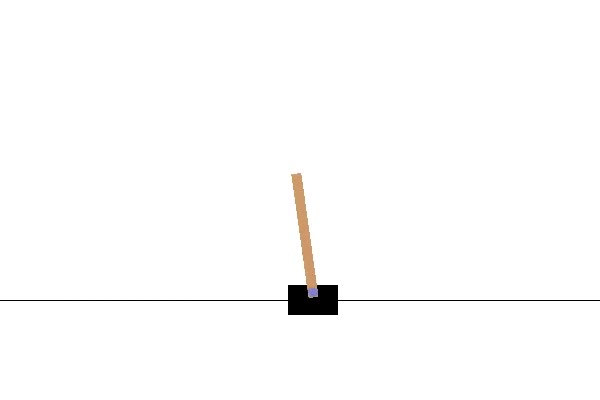


**CartPole-v1**
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

https://gym.openai.com/envs/CartPole-v1/



### 1. As usual, let's start with **importing libraries**!

In [1]:
import random 
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import math
import cv2
import time

import torch
from torch.distributions import Categorical
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

import gym                                    # this is for RL environment (https://gym.openai.com/)
from collections import deque               # this simplifies the implementation of the replay buffer



# For reproducibility, set seed for random functions.
SEED = 0

# set seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

### 2. Let's **mount Google drive** so that we can save files as we need.

In [3]:
from google.colab import drive
drive.mount("/content/drive")
import sys
import os

filepath = "/content/drive/My Drive/AIcapstone/RL_exercise3/Colab/"  # Change this path for your Google drive setting.
sys.path.append(filepath)
experiment = "CartPole_02C"

if not os.path.exists(f"{filepath}"):
    os.makedirs(f"{filepath}")
if not os.path.exists(f"{filepath}/{experiment}"):
    os.makedirs(f"{filepath}/{experiment}")

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### 3. We need a bunch of stuff for **visualization** (as we are running on server without a physical display!). Let's not worry about the details here.

In [4]:
!pip install gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg

from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML, clear_output
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

display = Display(visible=0, size=(400, 300))
display.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl xvfb
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 1,280 kB of archives.
After this operation, 7,687 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 1,280 kB in 3s (506 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 155455 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Selecting previously unselected package xvfb.
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.10_amd

### 4. Here's our function for visualization of the result as a **video**.

In [5]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

### 5. Let's make the **environment**.

In [6]:
ENV_NAME = "CartPole-v1"
env = gym.make(ENV_NAME) 
env.seed(SEED)

[0]

### 6. Let's define our **policy network**.

In [7]:
class policy_network(nn.Module):
    def __init__(self):
        super(policy_network, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)
        self.smax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.smax(x)

        return x

### 7. Here is **preprocessing** function for CartPole game.

In [8]:
def preprocess(state):
    return torch.Tensor(state).unsqueeze(0)

### 8. Define a function that converts a sequence of rewards into the requence of rewards.

$$r(t) \rightarrow \sum_{t' \geq t} \gamma^{t'-t} r_{t'}$$

In [9]:
def reward2return(rewards, gamma=0.99):
    seq_length = len(rewards)
    r = torch.zeros_like(rewards, dtype = float)
    for i in range(seq_length):
        t = seq_length-1-i

        if i==0:
            r[-1] = rewards[-1]
        else:
            r[t] = gamma*r[t+1] + rewards[t]
    return r

### 9. Here are our **hyperparameters**.

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

discount = 0.99         # discount factor gamma
max_time_steps = 1000    # maximum episode length. What will happen if we decrease or increase this?

reward_recent_history = deque(maxlen=30)  # for computing average reward over 30 episodes

### 10. Let's initialize our policy network.

In [11]:
# network and optimizer
pi = policy_network().to(device)
optimizer = torch.optim.Adam(pi.parameters(), lr=0.001)

action_space = np.arange(2)

### 11. Let's test the performance of the untrained network!

In [12]:
# TEST (with untrained policy network)
rewards = 0
state = preprocess(env.reset())
for t in range(max_time_steps):
    
    # choose action (by following the policy)
    action_probs = pi(state.to(device))        
    action_prob_detach = action_probs.detach().numpy()
    action = np.random.choice(action_space, p=action_prob_detach[0,:]) 

    # proceed one step (in the environment) 
    state_next, reward, done, _ = env.step(action)

    if done:
        break

    rewards = rewards + reward        
    state = preprocess(state_next)  

print("Total reward is " + str(rewards) + ".")

Total reward is 11.0.


### 12. Define a function to **keep track of the performance**.

In [13]:
def plt_history():
    clear_output(True)
    plt.figure(figsize=[16, 9])
    plt.title("Reward history")
    plt.plot(reward_history)
    
    plt.grid()
    plt.show()

### 13. Let's start **training**! We may choose one of the followings.



*   method1 (vanilla REINFORCE): $\nabla_{\theta}J(\theta) = \sum_{t \geq 0} \color{red}{ r(\tau)} \nabla_{\theta} \log \pi_{\theta} (a_t | s_t) $
*  method2 (causality): $\nabla_{\theta}J(\theta) = \sum_{t \geq 0} \color{red}{(\sum_{t'>t}r_{t'})} \nabla_{\theta} \log \pi_{\theta} (a_t | s_t) $
*  method3 (timing): $\nabla_{\theta}J(\theta) = \sum_{t \geq 0} \color{red}{(\sum_{t'>t} \gamma^{t'-t}r_{t'})} \nabla_{\theta} \log \pi_{\theta} (a_t | s_t) $





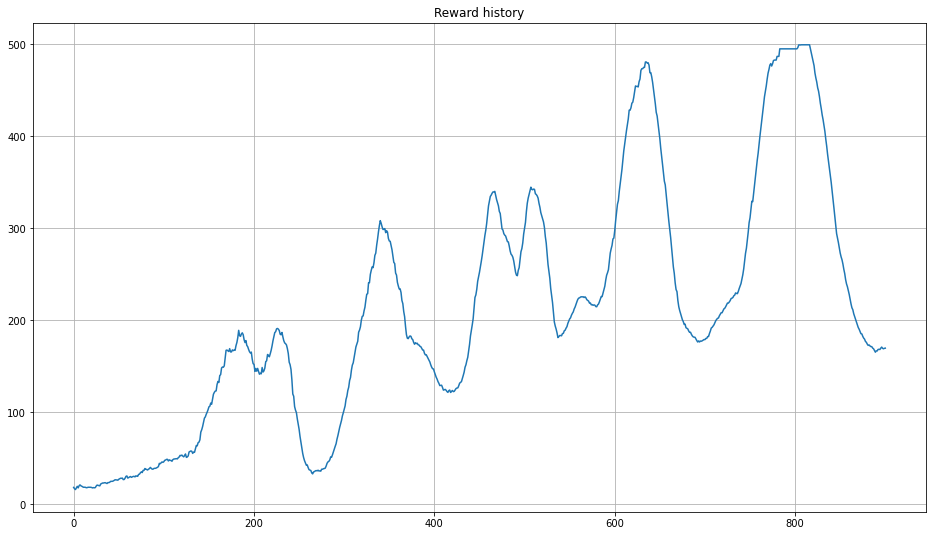

tensor(171.)


In [18]:
reward_history = []
method = 3

# define pooling layer (for moving average baseline calculation, only applies to method 4)
moving_avg = nn.AvgPool1d(41, stride=1, padding=20)

# training
for episode in range(1000):

    # initialization
    state = preprocess(env.reset())
    log_probs = torch.zeros(max_time_steps)
    rewards = torch.zeros(max_time_steps)

    # loop until an episode ends
    for t in range(max_time_steps):

        # choose action (by following the policy)  
        action_probs = pi(state.to(device))   # pi  
        action_prob_detach = action_probs.detach().numpy()   # just for detaching action_prob
        action = np.random.choice(action_space, p=action_prob_detach[0,:])   # randomly choose an action using action_prob_detach
        log_prob = torch.log(action_probs[0, action])   # calculate log prob for the chosen action       

        # proceed one step (in the environment) 
        state_next, reward, done, _ = env.step(action) 

        rewards[t] = reward
        log_probs[t] = log_prob

        if done:
            break
        state = preprocess(state_next)  

    # training with the recent episode
    rewards = rewards[0:t]
    log_probs = log_probs[0:t]
    
    # Before trying these methods, think about which one will be better.
    if method==1:
        x = reward2return(torch.FloatTensor(rewards), discount) 
        R = x[-1]                                           # vanilla REINFORCE
    elif method==2:
        R = reward2return(torch.FloatTensor(rewards), 1)    # REINFORCE with causality
    else:
        R = reward2return(torch.FloatTensor(rewards), discount) #REINFORCE with timing                                     
    
    # Calculate the loss 
    policy_loss = torch.sum(-log_probs*R)   # what is our policy loss

    # perform update 
    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()

    # Let's keep track of things
    reward_recent_history.append(rewards.sum())
    recent_average_reward = np.mean(reward_recent_history)
    reward_history.append(recent_average_reward)
    
    if episode%100 == 0:    
        plt_history()
        print(rewards.sum())


### 14. Now, let's **evaluate** the performance of the trained network!

In [19]:
env_vis = wrap_env(gym.make(ENV_NAME))
env_vis.seed(SEED + 1)
state = env_vis.reset()
state = preprocess(state)

In [20]:
current_epsilon = 0.0
done = False
score = 0
ep_len = 0


while not done and ep_len < max_time_steps:
    with torch.no_grad():
        
      # choose action (by following the policy)
      action_probs = pi(state.to(device))        
      action_prob_detach = action_probs.detach().numpy()
      action = np.random.choice(action_space, p=action_prob_detach[0,:]) 

      # proceed one step (in the environment) 
      state_next, reward, done, _ = env_vis.step(action)
      env_vis.render()   
      state = preprocess(state_next)  
      time.sleep(0.01)

env_vis.close()
show_video()

### **Congratulations**! You sucessfully trained an agent using REINFORCE!